In [1]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rl_sim/TactileDriven_Arto/UTILITIES')
from PreProcessingFunctions import WS, WS_B

from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from scipy.signal import butter, filtfilt
import traceback

import tensorflow
gpus = tensorflow.config.list_physical_devices('GPU')
# if gpus:    
#     for gpu in gpus:
#         tensorflow.config.set_logical_device_configuration(
#             gpu,
#             [tensorflow.config.LogicalDeviceConfiguration(memory_limit=48*1024)])  # Adjust memory limit as needed


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalMaxPooling2D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import BinaryCrossentropy
from tensorflow.keras.metrics    import AUC
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

def load_data(data_folder):
    X_data = []
    y_data = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            data = np.load(file_path)
            X_data.append(data['X'])
            y_data.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data


data_folder = '/home/rl_sim/TactileDriven_Arto/ML_Levers_Knobs/DATA/1D_TRANSF_KNOB_FTP_ScalNorm'

X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)
print("y_data.[0] max: ", np.max(y_data))

TEST_SIZE = 0.3
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)


print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)


data_dict = {
    "X_train": X_train,
    "X_test": X_test
}
def assign_and_deploy_variables(data_dict):
    for key, data in data_dict.items():
        globals()[f"{key}1"] = np.dstack((data[:,:,2], data[:,:,4]))
        globals()[f"{key}2"] = data[:,:,0]
        globals()[f"{key}3"] = data[:,:,5]
        globals()[f"{key}4"] = np.dstack((data[:,:,1], data[:,:,3]))

assign_and_deploy_variables(data_dict)

# Printing shapes
print("Shapes of the stacked arrays:")
print("X_train1 shape:", X_train1.shape)
print("X_train2 shape:", X_train2.shape)
print("X_train3 shape:", X_train3.shape)
print("X_train4 shape:", X_train4.shape)

import tensorflow as tf

WS_B = 2000  # Example sequence length
input_shape1 = (WS_B, 2)
input_shape2 = (WS_B, 1)
input_shape3 = (WS_B, 1)
input_shape4 = (WS_B, 2)
OUT_N = int(np.max(y_data)) + 1  # Plus one because labels are typically zero-indexed
DISP_LABELS = list(range(OUT_N))  # Generate labels from 0 to OUT_N-1
print("OUT_N:", OUT_N)
print("DISP_LABELS:", DISP_LABELS)

    
def compile_train_evaluate_plot(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32, patience=8, disp_labels=DISP_LABELS):
    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)

    # Predict labels for test data
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Plot training history
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    # Plot Loss Value
    axs[0].plot(history.history["loss"], label="loss (Training)")
    axs[0].set_title("Loss Value")
    axs[0].set_xlabel('Epoch')
    axs[0].legend()

    # Plot Accuracy
    axs[1].plot(history.history["accuracy"], label="accuracy")
    axs[1].set_title("Accuracy")
    axs[1].set_xlabel('Epoch')
    axs[1].legend()
    plt.tight_layout()
    plt.show()

    # Calculate additional metrics
    f1 = f1_score(y_test, y_pred_labels, average='macro') 
    accuracy = accuracy_score(y_test, y_pred_labels)

    print("Test loss:", loss)
    print("Test accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Classification Report:\n", classification_report(y_test, y_pred_labels))

    # Confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=disp_labels)
    disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()



2024-10-29 23:34:54.295942: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 23:34:54.324253: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-29 23:34:54.744343: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


X_data shape: (629, 2000, 9)
y_data shape: (629,)
X_data.[0] shape:  (2000, 9)
y_data.[0] max:  5.0
TOTAL DATA: 629  ||  Train = 70.0%  ||  Test = 30.0%
Dimensions of X_train: (440, 2000, 9)    ||  Dimensions of y_train: (440,)
Dimensions of X_test:  (189, 2000, 9)    ||  Dimensions of y_test:  (189,)
Shapes of the stacked arrays:
X_train1 shape: (440, 2000, 2)
X_train2 shape: (440, 2000)
X_train3 shape: (440, 2000)
X_train4 shape: (440, 2000, 2)
OUT_N: 6
DISP_LABELS: [0, 1, 2, 3, 4, 5]


2024-10-29 23:34:55.067459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 23:34:55.067626: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 23:34:55.095037: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

2024-10-29 23:34:55.400239: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 23:34:55.400394: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 23:34:55.400515: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 2000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 2000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 2000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 2000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 200, 64)   │      5,184 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 200, 64)   │      2,624 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 200, 64)   │      2,624 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_1 (Conv1D) │ (None, 200, 64)   │      5,184 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 99, 128)   │     32,896 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 99, 128)   │     32,896 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 99, 128)   │     32,896 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_2 (Conv1D) │ (None, 99, 128)   │     32,896 │ conv1d_4_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 99, 128)   │          0 │ conv1d_1_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 99, 128)   │          0 │ conv1d_2_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 99, 128)   │          0 │ conv1d_3_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4_1         │ (None, 99, 128)   │          0 │ conv1d_4_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 98, 256)   │     65,792 │ dropout_1_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 98, 256)   │     65,792 │ dropout_2_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 98, 256)   │     65,792 │ dropout_3_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_3 (Conv1D) │ (None, 98, 256)   │     65,792 │ dropout_4_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_1_1           │ (None, 256)       │          0 │ conv1d_1_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_2_1           │ (None, 256)       │          0 │ conv1d_2_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                 

 Total params: 477,110 (1.82 MB)

 Trainable params: 477,110 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80


I0000 00:00:1730241297.283106 2037666 service.cc:145] XLA service 0x55e4b1c4fbe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730241297.283131 2037666 service.cc:153]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
I0000 00:00:1730241297.283133 2037666 service.cc:153]   StreamExecutor device (1): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-10-29 23:34:57.322179: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-29 23:34:57.524814: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 1/14 ━━━━━━━━━━━━━━━━━━━━ 1:01 5s/step - accuracy: 0.2188 - loss: 1.7582

I0000 00:00:1730241300.675443 2037666 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.2619 - loss: 1.6926
Epoch 2/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3073 - loss: 1.4676 
Epoch 3/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4027 - loss: 1.4196 
Epoch 4/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4913 - loss: 1.2882 
Epoch 5/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4934 - loss: 1.2532 
Epoch 6/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4927 - loss: 1.2167 
Epoch 7/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5817 - loss: 1.1111 
Epoch 8/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5267 - loss: 1.1555 
Epoch 9/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5804 - loss: 1.0750 
Epoch 10/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5940 - loss: 1.0164 
Epoch 11/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6195 - loss: 0.9915 
Epoch 12/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6356 - l

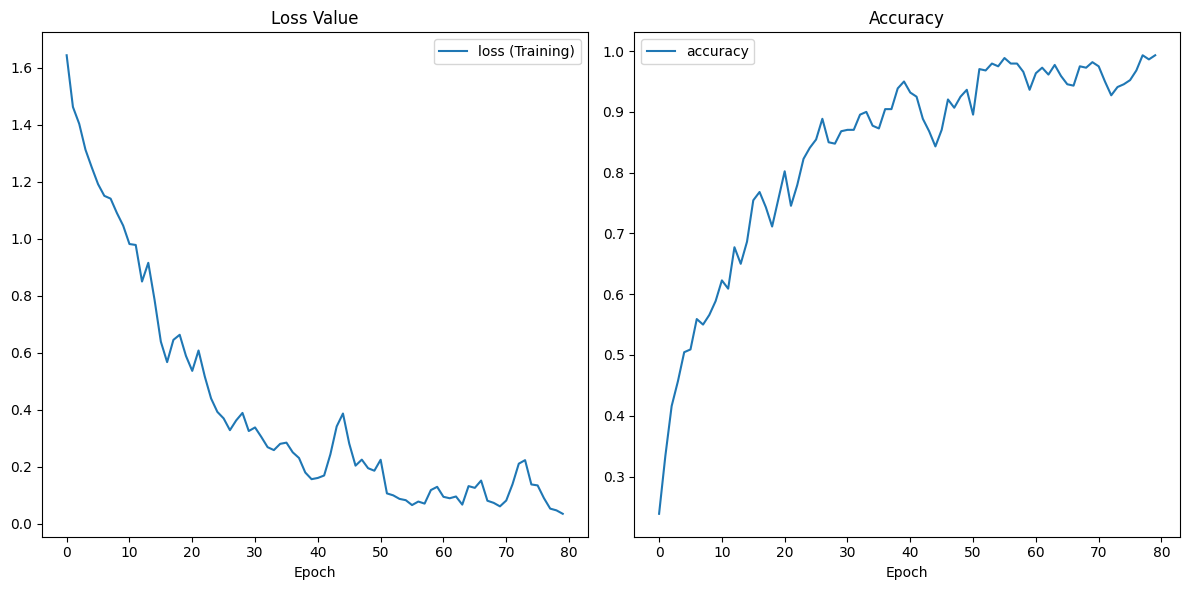

Test loss: 0.9187028408050537
Test accuracy: 0.8253968253968254
F1 Score: 0.8289138926565721
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.97      0.93        40
         1.0       0.88      0.71      0.78        51
         2.0       0.86      0.69      0.77        36
         3.0       0.90      0.95      0.93        20
         4.0       0.84      0.84      0.84        19
         5.0       0.60      0.91      0.72        23

    accuracy                           0.83       189
   macro avg       0.83      0.85      0.83       189
weighted avg       0.84      0.83      0.83       189



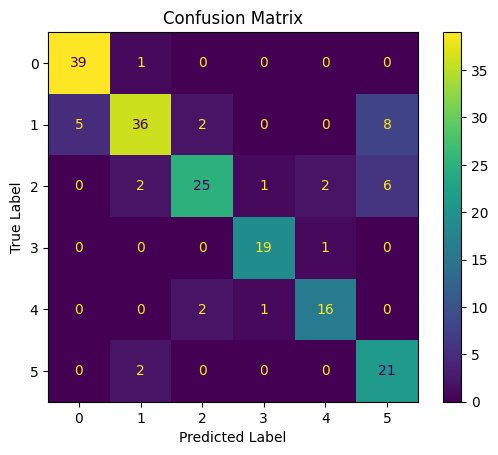

In [2]:
def build_branched_model(input_shapes):
    def create_branch(input_shape, branch_id):
        input_layer = Input(shape=input_shape, name=f'input{branch_id}')
        x = Conv1D(filters=64, kernel_size=40, strides=10, activation='relu', padding='same', name=f'conv1d_{branch_id}_1')(input_layer)
        #x = MaxPooling1D(pool_size=2)(x)
        x = Conv1D(filters=128, kernel_size=4, strides=2, activation='relu', name=f'conv1d_{branch_id}_2')(x)
        x = Dropout(rate=0.2, name=f'dropout_{branch_id}_1')(x)
        #x = MaxPooling1D(pool_size=4)(x)
        x = Conv1D(filters=256, kernel_size=2, strides=1, activation='relu', name=f'conv1d_{branch_id}_3')(x)
        x = GlobalMaxPooling1D(name=f'gap1d_{branch_id}_1')(x)
        return input_layer, x

    inputs = []
    branches = []
    
    for i, input_shape in enumerate(input_shapes, 1):
        input_layer, branch_output = create_branch(input_shape, i)
        inputs.append(input_layer)
        branches.append(branch_output)
    
    merged = concatenate(branches, name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage:
input_shapes = [input_shape1, input_shape2, input_shape3, input_shape4]
model = build_branched_model(input_shapes)
model.summary()

X_train = [X_train1, X_train2, X_train3, X_train4]
X_test  = [X_test1, X_test2, X_test3, X_test4]

compile_train_evaluate_plot(model, X_train, y_train, X_test, y_test, epochs=80, batch_size=32, patience=12, disp_labels=DISP_LABELS)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 2000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 2000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 2000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 2000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 500, 64)   │      2,624 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 500, 64)   │      1,344 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 500, 64)   │      1,344 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_1 (Conv1D) │ (None, 500, 64)   │      2,624 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 247, 128)  │     65,664 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 247, 128)  │     65,664 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 247, 128)  │     65,664 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_2 (Conv1D) │ (None, 247, 128)  │     65,664 │ conv1d_4_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 247, 128)  │          0 │ conv1d_1_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 247, 128)  │          0 │ conv1d_2_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 247, 128)  │          0 │ conv1d_3_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4_1         │ (None, 247, 128)  │          0 │ conv1d_4_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 246, 256)  │     65,792 │ dropout_1_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 246, 256)  │     65,792 │ dropout_2_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 246, 256)  │     65,792 │ dropout_3_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_3 (Conv1D) │ (None, 246, 256)  │     65,792 │ dropout_4_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_1_1           │ (None, 256)       │          0 │ conv1d_1_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_2_1           │ (None, 256)       │          0 │ conv1d_2_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                 

 Total params: 600,502 (2.29 MB)

 Trainable params: 600,502 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - accuracy: 0.2628 - loss: 1.6741
Epoch 2/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4549 - loss: 1.3289 
Epoch 3/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4111 - loss: 1.3660 
Epoch 4/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4880 - loss: 1.1839 
Epoch 5/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4437 - loss: 1.2808 
Epoch 6/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4929 - loss: 1.1074 
Epoch 7/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5454 - loss: 1.0451 
Epoch 8/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5393 - loss: 1.0140 
Epoch 9/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5669 - loss: 0.9517 
Epoch 10/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6151 - loss: 0.9178 
Epoch 11/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5672 - loss: 0.9492 
Epoch 12/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6610 - l

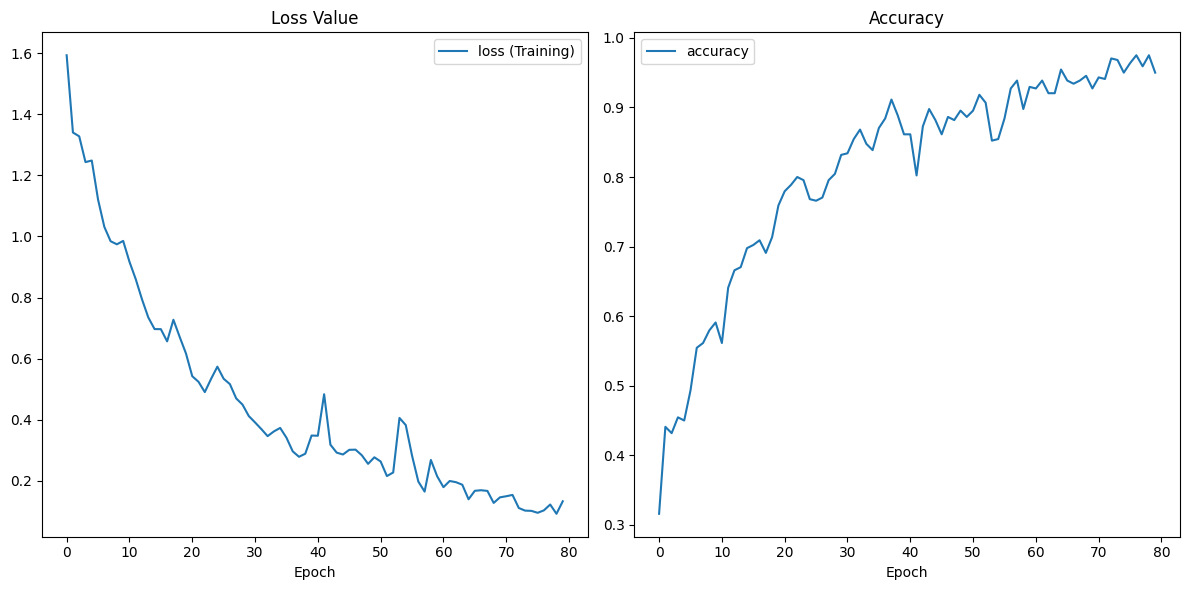

Test loss: 0.9783085584640503
Test accuracy: 0.7724867724867724
F1 Score: 0.7565360630993871
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      1.00      0.92        40
         1.0       1.00      0.69      0.81        51
         2.0       0.55      0.81      0.65        36
         3.0       0.87      0.65      0.74        20
         4.0       0.69      0.58      0.63        19
         5.0       0.78      0.78      0.78        23

    accuracy                           0.77       189
   macro avg       0.79      0.75      0.76       189
weighted avg       0.81      0.77      0.78       189



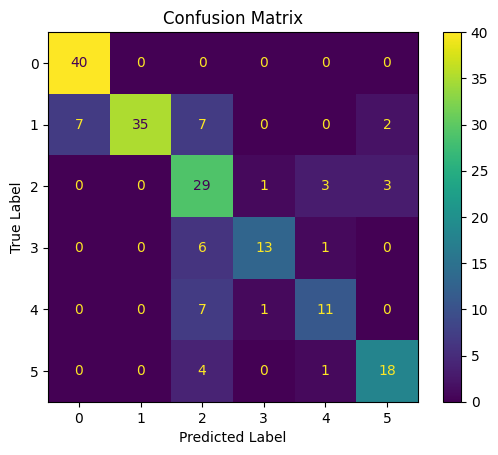

In [3]:
def build_branched_model(input_shapes):
    def create_branch(input_shape, branch_id):
        input_layer = Input(shape=input_shape, name=f'input{branch_id}')
        x = Conv1D(filters=64, kernel_size=20, strides=4, activation='relu', padding='same', name=f'conv1d_{branch_id}_1')(input_layer)
        #x = MaxPooling1D(pool_size=2)(x)
        x = Conv1D(filters=128, kernel_size=8, strides=2, activation='relu', name=f'conv1d_{branch_id}_2')(x)
        x = Dropout(rate=0.2, name=f'dropout_{branch_id}_1')(x)
        #x = MaxPooling1D(pool_size=4)(x)
        x = Conv1D(filters=256, kernel_size=2, strides=1, activation='relu', name=f'conv1d_{branch_id}_3')(x)
        x = GlobalMaxPooling1D(name=f'gap1d_{branch_id}_1')(x)
        return input_layer, x

    inputs = []
    branches = []
    
    for i, input_shape in enumerate(input_shapes, 1):
        input_layer, branch_output = create_branch(input_shape, i)
        inputs.append(input_layer)
        branches.append(branch_output)
    
    merged = concatenate(branches, name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage:
input_shapes = [input_shape1, input_shape2, input_shape3, input_shape4]
model = build_branched_model(input_shapes)
model.summary()


X_train = [X_train1, X_train2, X_train3, X_train4]
X_test  = [X_test1, X_test2, X_test3, X_test4]

compile_train_evaluate_plot(model, X_train, y_train, X_test, y_test, epochs=80, batch_size=32, patience=12, disp_labels=DISP_LABELS)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 2000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 2000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 2000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 2000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 40, 64)    │     12,864 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 40, 64)    │      6,464 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 40, 64)    │      6,464 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_1 (Conv1D) │ (None, 40, 64)    │     12,864 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 9, 128)    │     65,664 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 9, 128)    │     65,664 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 9, 128)    │     65,664 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_2 (Conv1D) │ (None, 9, 128)    │     65,664 │ conv1d_4_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 3, 256)    │    131,328 │ conv1d_1_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 3, 256)    │    131,328 │ conv1d_2_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 3, 256)    │    131,328 │ conv1d_3_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_3 (Conv1D) │ (None, 3, 256)    │    131,328 │ conv1d_4_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 3, 256)    │          0 │ conv1d_1_3[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 3, 256)    │          0 │ conv1d_2_3[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 3, 256)    │          0 │ conv1d_3_3[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4_1         │ (None, 3, 256)    │          0 │ conv1d_4_3[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_4 (Conv1D) │ (None, 2, 512)    │    262,656 │ dropout_1_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_4 (Conv1D) │ (None, 2, 512)    │    262,656 │ dropout_2_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_4 (Conv1D) │ (None, 2, 512)    │    262,656 │ dropout_3_1[0][0

 Total params: 2,010,662 (7.67 MB)

 Trainable params: 2,010,662 (7.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60


14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 276ms/step - accuracy: 0.1522 - loss: 1.7092
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5760 - loss: 1.0671 
Epoch 3/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6924 - loss: 0.7755 
Epoch 4/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7422 - loss: 0.6860 
Epoch 5/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7978 - loss: 0.5292 
Epoch 6/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8679 - loss: 0.3798 
Epoch 7/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8208 - loss: 0.4033 
Epoch 8/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8266 - loss: 0.3985 
Epoch 9/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9107 - loss: 0.2339 
Epoch 10/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9003 - loss: 0.2574 
Epoch 11/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9039 - loss: 0.2175 
Epoch 12/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9145 - l

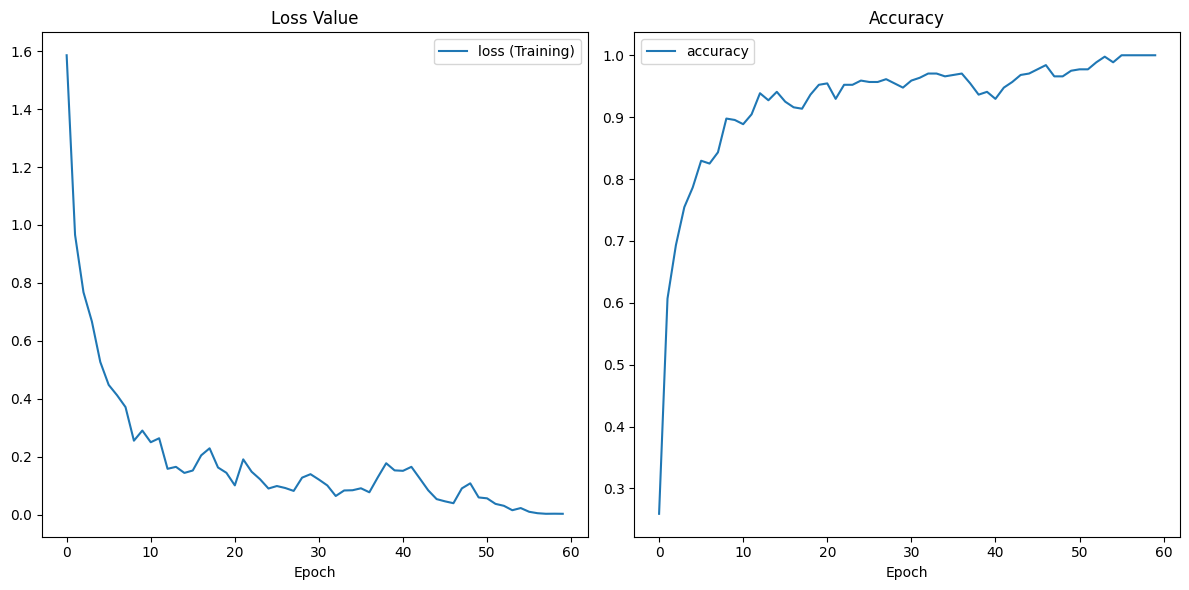

Test loss: 1.227936863899231
Test accuracy: 0.8465608465608465
F1 Score: 0.8409864706636059
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      1.00      0.94        40
         1.0       0.93      0.75      0.83        51
         2.0       0.81      0.83      0.82        36
         3.0       1.00      0.80      0.89        20
         4.0       0.73      1.00      0.84        19
         5.0       0.71      0.74      0.72        23

    accuracy                           0.85       189
   macro avg       0.84      0.85      0.84       189
weighted avg       0.86      0.85      0.85       189



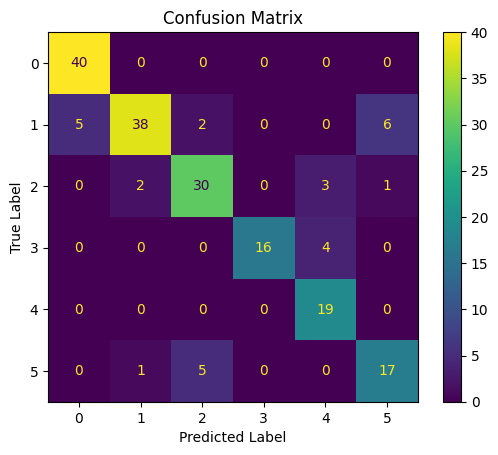

In [4]:
def build_branched_model(input_shapes):
    def create_branch(input_shape, branch_id):
        input_layer = Input(shape=input_shape, name=f'input{branch_id}')
        x = Conv1D(filters=64, kernel_size=100, strides=50, activation='relu', padding='same', name=f'conv1d_{branch_id}_1')(input_layer)
        #x = MaxPooling1D(pool_size=4)(x)
        x = Conv1D(filters=128, kernel_size=8, strides=4, activation='relu', name=f'conv1d_{branch_id}_2')(x)
        x = Conv1D(filters=256, kernel_size=4, strides=2, activation='relu', name=f'conv1d_{branch_id}_3')(x)
        #x = MaxPooling1D(pool_size=4)(x)
        x = Dropout(rate=0.2, name=f'dropout_{branch_id}_1')(x)
        x = Conv1D(filters=512, kernel_size=2, strides=1, activation='relu', name=f'conv1d_{branch_id}_4')(x)
        x = GlobalMaxPooling1D(name=f'gap1d_{branch_id}_1')(x)
        return input_layer, x

    inputs = []
    branches = []
    
    for i, input_shape in enumerate(input_shapes, 1):
        input_layer, branch_output = create_branch(input_shape, i)
        inputs.append(input_layer)
        branches.append(branch_output)
    
    merged = concatenate(branches, name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    dense = Dense(32, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage:
input_shapes = [input_shape1, input_shape2, input_shape3, input_shape4]
model = build_branched_model(input_shapes)
model.summary()

X_train = [X_train1, X_train2, X_train3, X_train4]
X_test  = [X_test1, X_test2, X_test3, X_test4]

compile_train_evaluate_plot(model, X_train, y_train, X_test, y_test, epochs=60, batch_size=32, patience=12, disp_labels=DISP_LABELS)

# THIS ONE HAS BEEN SAVED

In [6]:
# model_name = "KNOB_TRANSF_NoVal_85"
# from ML_models_functions import save_datasummary_and_results
# save_datasummary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model, assign_and_deploy_variables)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)